In [1]:
# import required modules
%cd /home/gridsan/lchan/git-remotes/polychrom_analysis
import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from post_processing.visualization import *
from post_processing.analysis import *
from post_processing.compscores import *
from post_processing.msd import *

import random
import csv
import math
from scipy.stats import rv_continuous

import nglutils as ngu
import nglview as nv

/home/gridsan/lchan/git-remotes/polychrom_analysis


In [2]:
conformations = list_URIs("/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/simple1/stickyBB_0_act1/runs500_200_200copies")
nblocks = 20 # for brevity
N = 1302
tau_values = np.asarray([2, 4, 6, 8, 10, 12, 14, 16]) # specify values here (in units of blocks)
# can choose tau values of (block) 1, 10, 100
num_tau_values = len(tau_values)
X = np.zeros((nblocks, 200*N, 3)) # position vectors

count_time = 0
for conf in conformations[:nblocks]:
    X[count_time] = load_URI(conf)['pos'] # special functions like load_URI can't be put into @jit
    count_time += 1
X = np.reshape(X, (nblocks, 200, N, 3))


In [3]:
V = np.zeros((nblocks, num_tau_values, 200, N, 3))

for i in range(nblocks - max(tau_values)): # i is t, j-i is tau
    for k, tau in enumerate(tau_values):
        j = i + tau
        V[i, k] = (X[j] - X[i])/tau # k is index of respective tau_value
ntimevalues = nblocks - max(tau_values)
step = 1
dt_values = np.arange(-ntimevalues + 1, ntimevalues, step) # should include 0
num_dt_values = len(dt_values)
dt_freqs = np.arange(1, ntimevalues + 1, step)
dt_freqs = np.concatenate((dt_freqs, dt_freqs[:-1][::-1]))

W = np.zeros((num_dt_values, num_tau_values, N, N)) # initialize array

In [4]:
for i in range(ntimevalues):
        for j in range(ntimevalues):
            for k, tau in enumerate(tau_values):
                dt = j-i
                dt_index = np.where(dt_values == dt)[0][0]
                tentative_dot = np.matmul(V[j, k], np.transpose(V[i, k], (0, 2, 1)))
                W[dt_index, k] += np.mean(tentative_dot, axis=0)
count_new = dt_freqs[:, np.newaxis, np.newaxis, np.newaxis]
W /= count_new

KeyboardInterrupt: 

[1 2 3 4 3 2 1]
[1 2 3 4 3 2 1]


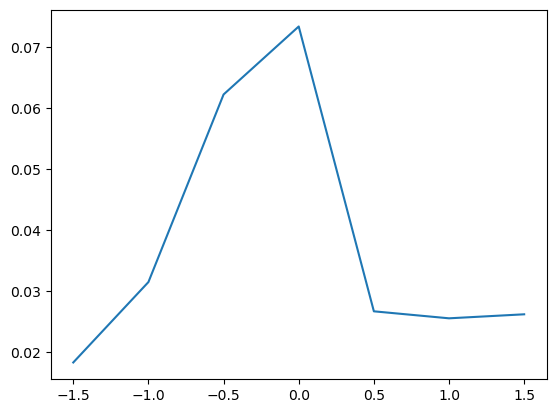

In [41]:
specify_i = 650 # A
specify_j = 850 # B
tau = tau_values[0]
ntimevalues = nblocks - max(tau_values)
step = 1
dt_values = np.arange(-ntimevalues + 1, ntimevalues, step)
dt_freqs = np.arange(1, ntimevalues + 1, step)
dt_freqs = np.concatenate((dt_freqs, dt_freqs[:-1][::-1]))
count_new = dt_freqs[:, np.newaxis, np.newaxis, np.newaxis]
print(dt_freqs)
print(count_new[:, 0, 0, 0])
plt.plot(dt_values / tau, W[:, 0, specify_i, specify_j])

In [10]:
@jit(nopython=True)
def velocity_corr_math_jit(X : np.ndarray, tau_values : np.ndarray):
    """ Calculte velocity correlation matrix W[dt, tau, i, j] given conformations
    and tau values used to construct velocity vectors.
    
    Parameters
    ----------
    X : np.ndarray[float] (nblocks, nchains, nmonomers, 3)
        (x, y, z) positions of chains over time
    tau_values : np.ndarray[float] (num_tau_values,)
        time separations used to construct velocity vectors, i.e. v[i] = x[t+tau] - x[t] / tau
    
    Returns
    -------
    W : np.ndarray[float] (num_dt_values, num_tau_values, N, N)
        velocity pair correlations between locus i and j as a function of time and tau
        
    """
    nblocks, nchains, N, _ = X.shape
    num_tau_values = len(tau_values)
    ntimevalues = nblocks - max(tau_values)
    
    step = 1 # stepping function for dt value
    dt_values = np.arange(-ntimevalues + 1, ntimevalues, step)
    num_dt_values = len(dt_values)
    dt_freqs = np.arange(1, ntimevalues + 1, step)
    dt_freqs = np.concatenate((dt_freqs, dt_freqs[:-1][::-1]))
    
    V = np.zeros((nblocks, num_tau_values, 200, N, 3))

    for i in prange(ntimevalues): # i is t, j-i is tau
        for k in prange(len(tau_values)):
            tau = tau_values[k]
            j = i + tau
            V[i, k] = (X[j] - X[i])/tau # k is index of respective tau_value
    
    W = np.zeros((num_dt_values, num_tau_values, N, N)) # initialize array
    
    for i in prange(ntimevalues):
        for j in prange(ntimevalues):
            for k in prange(len(tau_values)):
                dt = j-i
                dt_index = np.where(dt_values == dt)[0][0]
                # tentative_dot = np.matmul(V[j, k], np.transpose(V[i, k], (0, 2, 1))) 
                # convert this into for loop
                tentative_dot = np.zeros((N, N))
                for chain_i in prange(nchains):
                    arr = V[j, k, chain_i]
                    arr2 = V[i, k, chain_i]
                    #tentative_dot += arr + arr2
                    tentative_dot += np.dot(arr, arr2.T)
                W[dt_index, k] += tentative_dot / nchains
    count_new = dt_freqs[:, np.newaxis, np.newaxis, np.newaxis]
    W /= count_new
    return W

In [11]:
%%time
W = velocity_corr_math_jit(X, tau_values)

CPU times: user 1h 3min 21s, sys: 2min 10s, total: 1h 5min 31s
Wall time: 1min 32s


In [17]:
%%time
W = velocity_corr_math_jit(X, tau_values)

CPU times: user 1h 30min 51s, sys: 6min 24s, total: 1h 37min 15s
Wall time: 3min 18s


In [ ]:
# trying pytorch matmul implementation
import torch
def velocity_corr_torch(X, tau_values):
    nblocks, nchains, N, _ = X.shape
    num_tau_values = len(tau_values)
    ntimevalues = nblocks - max(tau_values)
    
    step = 1 # stepping function for dt value
    dt_values = torch.arange(-ntimevalues + 1, ntimevalues, step)
    num_dt_values = len(dt_values)
    dt_freqs = torch.arange(1, ntimevalues + 1, step)
    dt_freqs = torch.cat((dt_freqs, dt_freqs[:-1].flip(0)))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # ???

    V = torch.zeros((nblocks, num_tau_values, 200, N, 3), device=device)

    for i in range(ntimevalues): # i is t, j-i is tau
        for k, tau in enumerate(tau_values):
            j = i + tau
            V[i, k] = (X[j] - X[i])/tau # k is index of respective tau_value
    
    W = torch.zeros((num_dt_values, num_tau_values, N, N), device=device) # initialize array
    
    for i in range(ntimevalues):
        for j in range(ntimevalues):
            for k, tau in enumerate(tau_values):
                dt = j-i
                dt_index = torch.where(dt_values == dt)[0][0]
                tentative_dot = torch.matmul(V[j, k], V[i, k].transpose(1, 2))
                W[dt_index, k] += tentative_dot.mean(dim=0)
    count_new = dt_freqs[:, None, None, None]
    W /= count_new
    return W

KeyboardInterrupt: 

In [ ]:
%time
W = velocity_corr_torch(X, tau_values)

In [ ]:

# how to jit with parallelizaiton

In [5]:
array1 = np.random.rand(4, 3)
array2 = np.random.rand(4, 3)

@jit(nopython=True)
def matmul_transpose(a, b):
    return np.dot(a, b.T)


In [6]:
matmul_transpose(array1, array2)

array([[0.58310131, 0.682031  , 0.68943195, 0.83385245],
       [0.36270391, 0.61912145, 0.5223386 , 0.87660291],
       [0.86233961, 0.82689551, 1.19567271, 1.42723316],
       [0.85617689, 0.87926973, 1.18504332, 1.46383689]])

In [8]:
%%timeit
array1 = np.random.rand(4, 3)
array2 = np.random.rand(4, 3)
matmul_transpose(array1, array2)

7.98 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [31]:
from numba import njit, prange

@jit(nopython=True)
def get_velocity_matrix(X, tau_values):
    nblocks, nchains, N, _ = X.shape
    num_tau_values = len(tau_values)
    ntimevalues = nblocks - max(tau_values)
    V = np.zeros((nblocks, num_tau_values, 200, N, 3))

    for i in prange(ntimevalues): # i is t, j-i is tau
        for k in prange(len(tau_values)):
            tau = tau_values[k]
            j = i + tau
            V[i, k] = (X[j] - X[i])/tau # k is index of respective tau_value
    return V

@njit(parallel=True)
def get_velocity_matrix_parallel(X, tau_values):
    nblocks, nchains, N, _ = X.shape
    num_tau_values = len(tau_values)
    ntimevalues = nblocks - max(tau_values)
    V = np.zeros((nblocks, num_tau_values, 200, N, 3))

    for i in prange(ntimevalues): # i is t, j-i is tau
        for k in prange(len(tau_values)):
            tau = tau_values[k]
            j = i + tau
            V[i, k] = (X[j] - X[i])/tau # k is index of respective tau_value
    return V

In [32]:
%%timeit
V = get_velocity_matrix(X, tau_values)

434 ms ± 96.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
V = get_velocity_matrix_parallel(X, tau_values)

215 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
@jit(nopython=True)
def get_vel_corr_from_V(V, tau_values):
    nblocks, num_tau_values, nchains, N, _ = V.shape
    ntimevalues = nblocks - max(tau_values)
    step = 1 # stepping function for dt value
    dt_values = np.arange(-ntimevalues + 1, ntimevalues, step)
    num_dt_values = len(dt_values)
    dt_freqs = np.arange(1, ntimevalues + 1, step)
    dt_freqs = np.concatenate((dt_freqs, dt_freqs[:-1][::-1]))
    
    W = np.zeros((num_dt_values, num_tau_values, N, N)) # initialize array
    
    for i in prange(ntimevalues):
        for j in prange(ntimevalues):
            for k in prange(len(tau_values)):
                dt = j-i
                dt_index = np.where(dt_values == dt)[0][0]
                # tentative_dot = np.matmul(V[j, k], np.transpose(V[i, k], (0, 2, 1))) 
                # convert this into for loop
                tentative_dot = np.zeros((N, N))
                for chain_i in prange(nchains):
                    arr = V[j, k, chain_i]
                    arr2 = V[i, k, chain_i]
                    #tentative_dot += arr + arr2
                    tentative_dot += np.dot(arr, arr2.T)
                W[dt_index, k] += tentative_dot / nchains
    return W

@njit(parallel=True)
def get_vel_corr_from_V_parallel(V, tau_values):
    nblocks, num_tau_values, nchains, N, _ = V.shape
    ntimevalues = nblocks - max(tau_values)
    step = 1 # stepping function for dt value
    dt_values = np.arange(-ntimevalues + 1, ntimevalues, step)
    num_dt_values = len(dt_values)
    dt_freqs = np.arange(1, ntimevalues + 1, step)
    dt_freqs = np.concatenate((dt_freqs, dt_freqs[:-1][::-1]))
    
    W = np.zeros((num_dt_values, num_tau_values, N, N)) # initialize array
    
    for i in prange(ntimevalues):
        for j in prange(ntimevalues):
            for k in prange(len(tau_values)):
                dt = j-i
                dt_index = np.where(dt_values == dt)[0][0]
                # tentative_dot = np.matmul(V[j, k], np.transpose(V[i, k], (0, 2, 1))) 
                # convert this into for loop
                tentative_dot = np.zeros((N, N))
                for chain_i in prange(nchains):
                    arr = V[j, k, chain_i]
                    arr2 = V[i, k, chain_i]
                    #tentative_dot += arr + arr2
                    tentative_dot += np.dot(arr, arr2.T)
                W[dt_index, k] += tentative_dot / nchains
    return W

In [36]:
%%time
W = get_vel_corr_from_V(V, tau_values)

CPU times: user 2h 18min 19s, sys: 5min 53s, total: 2h 24min 13s
Wall time: 3min 54s


In [37]:
%%time
W = get_vel_corr_from_V_parallel(V, tau_values)

CPU times: user 15min 8s, sys: 59min 35s, total: 1h 14min 43s
Wall time: 1min 6s


In [38]:
get_vel_corr_from_V_parallel.parallel_diagnostics()

 
 Parallel Accelerator Optimizing:  Function get_vel_corr_from_V_parallel, 
/state/partition1/slurm_tmp/26128774.0.0/ipykernel_1463209/3586121348.py (29)  


Parallel loop listing for  Function get_vel_corr_from_V_parallel, /state/partition1/slurm_tmp/26128774.0.0/ipykernel_1463209/3586121348.py (29) 
-------------------------------------------------------------------------------------------|loop #ID
@njit(parallel=True)                                                                       | 
def get_vel_corr_from_V_parallel(V, tau_values):                                           | 
    nblocks, num_tau_values, nchains, N, _ = V.shape                                       | 
    ntimevalues = nblocks - max(tau_values)                                                | 
    step = 1 # stepping function for dt value                                              | 
    dt_values = np.arange(-ntimevalues + 1, ntimevalues, step)                             | 
    num_dt_values = len(dt_valu